# Test Dataloader in dataset.py

In [15]:
# install packages
import yaml
import os
import json
from torch.utils.data import Dataset
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image
import matplotlib.pyplot as plt
from pycocotools import mask as coco_mask
from pycocotools.coco import COCO


Import Data/Annotations

In [16]:
config_file_path = '/home/Alexandra/Projects/bodycondition/sharkbody_seg/runs/unet_smp/demo_run/config/config.yaml' # config file path
with open(config_file_path, 'r') as file: cfg = yaml.safe_load(file) # load yaml as cfg

Functions from earth_obs_seg (Bjorn)

In [4]:
class SharkBody(Dataset): # from ct-classifier

    def __init__(self, cfg, split='train'): # collect and index dataset inputs/labels
        self.data_root = cfg['data_root'] # root folder
        self.split = split # determine split

        self.transform = Compose([ # transform: resize/convert to torch tensor and (opt.) augmentation      
            Resize((cfg['image_size'], cfg['image_size'])), ToTensor()])

        annotations_path = os.path.join( # path to annotations
            self.data_root, 'annotations', 
            'train.json' if self.split == 'train' else ('val.json' if self.split == 'val' else 'test.json')) # choose one of three splits

        self.coco = COCO(annotations_path) 
        self.shark_bodies = [] # for storing masks
        self.annotation_ids = self.coco.getAnnIds(catIds = [1])
        self.annotations = self.coco.loadAnns(self.annotation_ids)
        
        for ann in self.annotations: # loop through annotations and store
            image_id = ann['image_id']
            file_name = self.coco.loadImgs(image_id)[0]['file_name']
            binary_mask = self.coco.annToMask(ann)  
            
            self.shark_bodies.append({ # store image and mask data
                'image_id': image_id,
                'file_name': file_name,
                'mask': binary_mask
            })
            
            # append image-label tuple to data
            imgFileName = images[imgID]
            label = anno['category_id'] # return a MASK 
            labelIndex = labels[label]
            self.data.append([imgFileName, labelIndex])
            images_covered.add(imgID)       # make sure image is only added once to dataset
    

    def __len__(self):
        return len(self.data)

    
    def __getitem__(self, idx):

        image_name, label = self.data[idx]

        # load image
        image_path = os.path.join(self.data_root, 'images', image_name)
        img = Image.open(image_path).convert('RGB')   # the ".convert" makes sure we always get three bands in Red, Green, Blue order

        # transform: see lines 31ff above where we define our transformations
        img_tensor = self.transform(img)

        return img_tensor, label

# Test each function

In [5]:
# instantiate shark body
dataset = SharkBody(cfg, split='train')

In [6]:
# load example image
image_path = '/mnt/class_data/group2/alexandradigiacomo/dataset/images/05122024PAMB0101.JPG'  # first image
img = Image.open(image_path).convert('RGB')

In [7]:
# test data loader
for i in range(5):
    print(dataset[i])  # Should print (image_tensor, label)

(tensor([[[0.4588, 0.4549, 0.4510,  ..., 0.3725, 0.3686, 0.3725],
         [0.4549, 0.4510, 0.4510,  ..., 0.3725, 0.3686, 0.3725],
         [0.4549, 0.4510, 0.4510,  ..., 0.3765, 0.3765, 0.3765],
         ...,
         [0.3922, 0.3882, 0.3843,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3843, 0.3843,  ..., 0.3725, 0.3725, 0.3765],
         [0.3882, 0.3804, 0.3843,  ..., 0.3725, 0.3725, 0.3765]],

        [[0.6235, 0.6196, 0.6196,  ..., 0.5647, 0.5608, 0.5608],
         [0.6196, 0.6196, 0.6196,  ..., 0.5647, 0.5608, 0.5608],
         [0.6196, 0.6157, 0.6196,  ..., 0.5647, 0.5647, 0.5608],
         ...,
         [0.5686, 0.5686, 0.5647,  ..., 0.5529, 0.5529, 0.5569],
         [0.5686, 0.5647, 0.5647,  ..., 0.5529, 0.5529, 0.5569],
         [0.5686, 0.5647, 0.5647,  ..., 0.5529, 0.5569, 0.5569]],

        [[0.5451, 0.5412, 0.5451,  ..., 0.4392, 0.4353, 0.4353],
         [0.5412, 0.5412, 0.5412,  ..., 0.4392, 0.4353, 0.4353],
         [0.5412, 0.5373, 0.5412,  ..., 0.4392, 0.4392, 0

In [8]:
# test len function
print(len(dataset)) 

888


In [9]:
# test the __getitem__ function
img_tensor, label = dataset[0]

# Check the shape of the image tensor and label
print(f"Image tensor shape: {img_tensor.shape}")  # Should match (3, height, width)
print(f"Label: {label}")  # Should print the corresponding label index=

Image tensor shape: torch.Size([3, 224, 224])
Label: 0


AttributeError: 'int' object has no attribute 'squeeze'

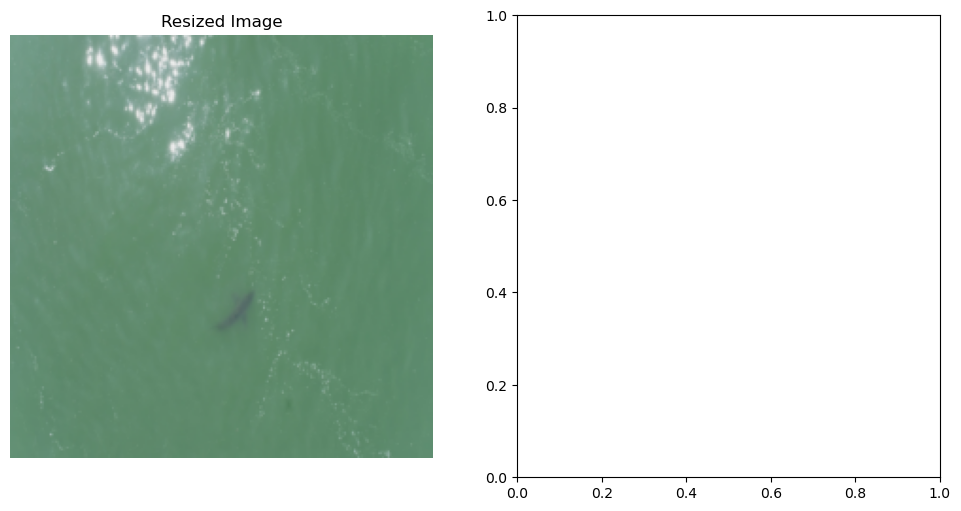

In [13]:
img_display = img_tensor.permute(1, 2, 0)  # convert image tensor

fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # image
axes[0].imshow(img_display)
axes[0].set_title(f"Resized Image")
axes[0].axis('off')

axes[1].imshow(label.squeeze(), cmap='gray')  # Use .squeeze() if mask has an extra dimension; plot it
axes[1].set_title("Mask")
axes[1].axis('off')

plt.show()

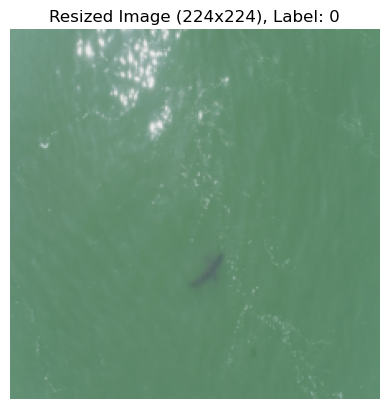

Label: 0


In [ ]:
plt.imshow(img_display) # display
plt.title(f"Resized Image (224x224), Label: {label}")
plt.axis('off')  # Hide axis
plt.show()

print(f"Label: {label}") # print the label